# Logits to Categorical Distribution

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
PI = torch.Tensor([math.pi])

In [4]:
def create_animation_logits(intermediate_results):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    sc = ax.scatter(preds[:, 0], preds[:, 1], preds[:, 2], c=target)

    # manually relim:
    xmin = 1e7; xmax = 1e-7;
    ymin = 1e7; ymax = 1e-7;
    zmin = 1e7; zmax = 1e-7;
    for preds in intermediate_results:
        xmin=min(preds[:,0].min(), xmin); xmax=max(preds[:,0].max(), xmax)
        ymin=min(preds[:,1].min(), ymin); ymax=max(preds[:,1].max(), ymax)
        zmin=min(preds[:,2].min(), zmin); zmax=max(preds[:,2].max(), zmax)

    xmin = max(xmin, -10.); xmax = min(xmax, 10.)
    ymin = max(xmin, -10.); ymax = min(ymax, 10.)
    zmin = max(xmin, -10.); zmax = min(zmax, 10.)

    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets3d = (preds[:, 0], preds[:, 1], preds[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    
    return ani

In [5]:
def create_animation_simplex(intermediate_results, target):
    
    fig, ax = plt.subplots()
    
    probs = softmax(intermediate_results[0], 1)
    
    ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')
    
    def update_scat(i):
        probs = softmax(intermediate_results[i], 1)
        for j, collection in enumerate(ax.ax.collections):
            collection.set_offsets(np.array(project_sequence(probs[target==j])).T)
        ax._redraw_labels()

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [6]:
def nll(probs, target):
    return np.mean(-np.log(probs[np.arange(probs.shape[0]), target]))

## Base distributions of uncalibrated logits

* Separable case
* Mixed case

In [7]:
n_samples = 1500
dim = 3

### Separable

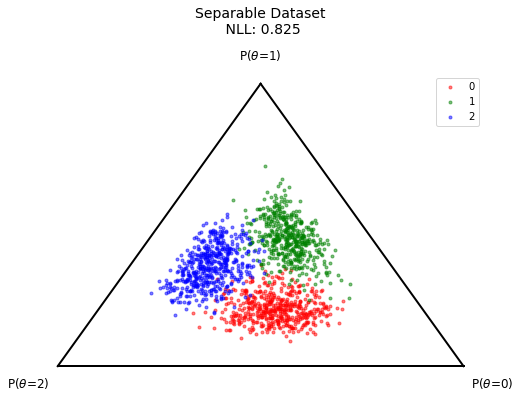

In [8]:
easy_target = np.array(random.choices(range(3), k=n_samples))
one_hot = np.zeros((n_samples, 3))
one_hot[np.arange(n_samples), easy_target] = 1.

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), easy_target-1] = 0.7 + np.random.randn(n_samples)*0.1

easy_logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# Equivalent to log(softmax())
easy_logits -= np.log(np.sum(np.exp(easy_logits), axis=1, keepdims=True))

easy_probs = softmax(easy_logits, axis=1)

# Convert data to torch tensors.
torch_easy_logits = torch.as_tensor(easy_logits, dtype=torch.float)
torch_easy_target = torch.as_tensor(easy_target, dtype=torch.long)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(easy_probs, easy_target, ax=ax, title='Separable Dataset\n NLL: {:.3f}'.format(nll(easy_probs, easy_target)))

plt.show(fig)

### Mixed

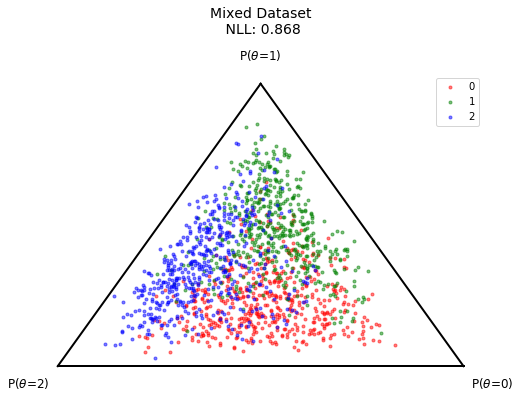

In [9]:
hard_target = np.array(random.choices(range(dim), k=n_samples))
one_hot = np.zeros((n_samples, dim))
one_hot[np.arange(n_samples), hard_target] = 1.

# Shift
offset = np.zeros((n_samples, dim))
offset[:, 1:] = 0.2

# Twist
twisting = np.zeros((n_samples, dim))
twisting[np.arange(n_samples), hard_target-1] = 0.6 + np.random.randn(n_samples)*0.3

hard_logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, dim)*0.6) + offset)

# Equivalent to log(softmax())
hard_logits -= np.log(np.sum(np.exp(hard_logits), axis=1, keepdims=True))

hard_probs = softmax(hard_logits, axis=1)

# Convert data to torch tensors.
torch_hard_logits = torch.as_tensor(hard_logits, dtype=torch.float)
torch_hard_target = torch.as_tensor(hard_target, dtype=torch.long)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(hard_probs, hard_target, ax=ax, title='Mixed Dataset\n NLL: {:.3f}'.format(nll(hard_probs, hard_target)))

plt.show(fig)

## Define Flows

In [10]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [11]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [12]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_size=[5, 5], random_mask=True, max_abs=None):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, hidden_size)
        self.t = MLP(dim, hidden_size)
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        if random_mask:
            while mask.sum() < 1 or mask.sum() == dim:
                mask = np.random.randint(2, size=dim)
        else:
            mask = np.zeros((1, dim))
            mask[:, dim//2:] = 1
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)
        
        self.max_abs = max_abs

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

In [13]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.log_det = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        zs = []
        for layer in self.layers:
            x, log_det = layer(x)
            zs.append(x)
            cum_log_det += log_det
            
        return zs, cum_log_det
            
    def backward(self, z):
        cum_log_det = self.log_det.new_full((z.shape[0],), fill_value=0)
        xs = []
        for layer in self.layers[::-1]:
            z, log_det = layer.backward(z)
            xs.append(z)
            cum_log_det += log_det

        return xs, cum_log_det

## NVP-like flow separable case

In [14]:
model = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])
dev = torch.device('cpu')

In [15]:
epochs = 15000

In [16]:
model = model.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss = []
logpz = []
logdet = []

n_layers = 5  # Layers to monitor

# Output at some layers
logits_mean = []
logits_size = []

softmx = nn.Softmax(dim=1)

intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    zs, _logdet = model(torch_easy_logits)
    preds = zs[-1]
    _probs = softmx(preds)
    
    if (_probs != _probs).any():
        break
    
    means = []
    sizes = []
    for i in range(0, len(model.layers), len(model.layers)//n_layers):
        z = zs[i].detach().numpy()
        means.append(np.mean(z))
        sizes.append(np.mean(np.linalg.norm(z-np.mean(z, axis=1, keepdims=True), axis=1)))

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_easy_target.view(-1, 1))))
    _loss = -_logpz - _logdet


    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logpz.append(_logpz.item())
    logdet.append(_logdet.item())
    
    logits_mean.append(means)
    logits_size.append(sizes)

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1])
              + ', log(det): {:.3f}, mean(logits): {:.3f}, size(logits): {:.3f}'.format(logdet[-1],
                                                                                        np.mean(np.array(logits_mean[-1])),
                                                                                        np.mean(np.array(logits_size[-1])))
             )
        intermediate_results.append(preds.detach().numpy())

epoch: 9, at time: 0.26, loss: 1.614, log(pz): -0.944, log(det): -0.670, mean(logits): -1.304, size(logits): 1.037
epoch: 19, at time: 0.46, loss: 1.611, log(pz): -0.944, log(det): -0.667, mean(logits): -1.305, size(logits): 1.037
epoch: 29, at time: 0.68, loss: 1.607, log(pz): -0.943, log(det): -0.663, mean(logits): -1.306, size(logits): 1.036
epoch: 39, at time: 0.89, loss: 1.603, log(pz): -0.943, log(det): -0.660, mean(logits): -1.306, size(logits): 1.036
epoch: 49, at time: 1.10, loss: 1.599, log(pz): -0.942, log(det): -0.657, mean(logits): -1.307, size(logits): 1.036
epoch: 59, at time: 1.32, loss: 1.595, log(pz): -0.942, log(det): -0.653, mean(logits): -1.308, size(logits): 1.035
epoch: 69, at time: 1.53, loss: 1.591, log(pz): -0.941, log(det): -0.650, mean(logits): -1.308, size(logits): 1.035
epoch: 79, at time: 1.75, loss: 1.587, log(pz): -0.941, log(det): -0.647, mean(logits): -1.309, size(logits): 1.035
epoch: 89, at time: 1.98, loss: 1.583, log(pz): -0.940, log(det): -0.643,

epoch: 709, at time: 15.49, loss: 1.350, log(pz): -0.915, log(det): -0.434, mean(logits): -1.347, size(logits): 1.025
epoch: 719, at time: 15.70, loss: 1.346, log(pz): -0.915, log(det): -0.431, mean(logits): -1.348, size(logits): 1.025
epoch: 729, at time: 15.92, loss: 1.342, log(pz): -0.914, log(det): -0.428, mean(logits): -1.349, size(logits): 1.025
epoch: 739, at time: 16.13, loss: 1.339, log(pz): -0.914, log(det): -0.424, mean(logits): -1.349, size(logits): 1.025
epoch: 749, at time: 16.36, loss: 1.335, log(pz): -0.914, log(det): -0.421, mean(logits): -1.350, size(logits): 1.025
epoch: 759, at time: 16.57, loss: 1.331, log(pz): -0.914, log(det): -0.418, mean(logits): -1.350, size(logits): 1.025
epoch: 769, at time: 16.78, loss: 1.328, log(pz): -0.913, log(det): -0.414, mean(logits): -1.351, size(logits): 1.025
epoch: 779, at time: 17.00, loss: 1.324, log(pz): -0.913, log(det): -0.411, mean(logits): -1.352, size(logits): 1.025
epoch: 789, at time: 17.21, loss: 1.320, log(pz): -0.913

epoch: 1409, at time: 30.62, loss: 1.097, log(pz): -0.898, log(det): -0.198, mean(logits): -1.385, size(logits): 1.036
epoch: 1419, at time: 30.84, loss: 1.093, log(pz): -0.898, log(det): -0.195, mean(logits): -1.386, size(logits): 1.036
epoch: 1429, at time: 31.05, loss: 1.089, log(pz): -0.898, log(det): -0.191, mean(logits): -1.386, size(logits): 1.037
epoch: 1439, at time: 31.27, loss: 1.086, log(pz): -0.898, log(det): -0.188, mean(logits): -1.386, size(logits): 1.037
epoch: 1449, at time: 31.48, loss: 1.082, log(pz): -0.898, log(det): -0.185, mean(logits): -1.387, size(logits): 1.037
epoch: 1459, at time: 31.70, loss: 1.079, log(pz): -0.898, log(det): -0.181, mean(logits): -1.387, size(logits): 1.038
epoch: 1469, at time: 31.91, loss: 1.075, log(pz): -0.897, log(det): -0.178, mean(logits): -1.388, size(logits): 1.038
epoch: 1479, at time: 32.12, loss: 1.072, log(pz): -0.897, log(det): -0.174, mean(logits): -1.388, size(logits): 1.038
epoch: 1489, at time: 32.34, loss: 1.068, log(pz

epoch: 2099, at time: 45.56, loss: 0.851, log(pz): -0.888, log(det): 0.037, mean(logits): -1.413, size(logits): 1.071
epoch: 2109, at time: 45.77, loss: 0.848, log(pz): -0.888, log(det): 0.040, mean(logits): -1.414, size(logits): 1.071
epoch: 2119, at time: 45.98, loss: 0.844, log(pz): -0.888, log(det): 0.044, mean(logits): -1.414, size(logits): 1.072
epoch: 2129, at time: 46.20, loss: 0.841, log(pz): -0.888, log(det): 0.047, mean(logits): -1.414, size(logits): 1.072
epoch: 2139, at time: 46.42, loss: 0.837, log(pz): -0.888, log(det): 0.051, mean(logits): -1.415, size(logits): 1.073
epoch: 2149, at time: 46.63, loss: 0.834, log(pz): -0.888, log(det): 0.054, mean(logits): -1.415, size(logits): 1.074
epoch: 2159, at time: 46.85, loss: 0.830, log(pz): -0.888, log(det): 0.058, mean(logits): -1.415, size(logits): 1.074
epoch: 2169, at time: 47.06, loss: 0.827, log(pz): -0.888, log(det): 0.061, mean(logits): -1.416, size(logits): 1.075
epoch: 2179, at time: 47.27, loss: 0.823, log(pz): -0.88

epoch: 2799, at time: 60.69, loss: 0.604, log(pz): -0.879, log(det): 0.275, mean(logits): -1.436, size(logits): 1.122
epoch: 2809, at time: 60.90, loss: 0.601, log(pz): -0.879, log(det): 0.278, mean(logits): -1.436, size(logits): 1.123
epoch: 2819, at time: 61.14, loss: 0.597, log(pz): -0.879, log(det): 0.282, mean(logits): -1.436, size(logits): 1.124
epoch: 2829, at time: 61.36, loss: 0.594, log(pz): -0.879, log(det): 0.285, mean(logits): -1.437, size(logits): 1.125
epoch: 2839, at time: 61.57, loss: 0.590, log(pz): -0.879, log(det): 0.289, mean(logits): -1.437, size(logits): 1.126
epoch: 2849, at time: 61.79, loss: 0.587, log(pz): -0.879, log(det): 0.292, mean(logits): -1.437, size(logits): 1.127
epoch: 2859, at time: 62.01, loss: 0.583, log(pz): -0.879, log(det): 0.295, mean(logits): -1.437, size(logits): 1.127
epoch: 2869, at time: 62.22, loss: 0.580, log(pz): -0.878, log(det): 0.299, mean(logits): -1.438, size(logits): 1.128
epoch: 2879, at time: 62.44, loss: 0.576, log(pz): -0.87

epoch: 3499, at time: 75.88, loss: 0.358, log(pz): -0.866, log(det): 0.508, mean(logits): -1.456, size(logits): 1.180
epoch: 3509, at time: 76.09, loss: 0.355, log(pz): -0.866, log(det): 0.511, mean(logits): -1.456, size(logits): 1.181
epoch: 3519, at time: 76.32, loss: 0.352, log(pz): -0.866, log(det): 0.515, mean(logits): -1.456, size(logits): 1.182
epoch: 3529, at time: 76.53, loss: 0.348, log(pz): -0.866, log(det): 0.518, mean(logits): -1.457, size(logits): 1.183
epoch: 3539, at time: 76.75, loss: 0.345, log(pz): -0.866, log(det): 0.521, mean(logits): -1.457, size(logits): 1.184
epoch: 3549, at time: 76.97, loss: 0.341, log(pz): -0.865, log(det): 0.524, mean(logits): -1.457, size(logits): 1.185
epoch: 3559, at time: 77.18, loss: 0.338, log(pz): -0.865, log(det): 0.528, mean(logits): -1.458, size(logits): 1.186
epoch: 3569, at time: 77.40, loss: 0.334, log(pz): -0.865, log(det): 0.531, mean(logits): -1.458, size(logits): 1.187
epoch: 3579, at time: 77.62, loss: 0.331, log(pz): -0.86

epoch: 4199, at time: 91.00, loss: 0.117, log(pz): -0.853, log(det): 0.736, mean(logits): -1.475, size(logits): 1.245
epoch: 4209, at time: 91.21, loss: 0.114, log(pz): -0.853, log(det): 0.739, mean(logits): -1.475, size(logits): 1.246
epoch: 4219, at time: 91.43, loss: 0.110, log(pz): -0.852, log(det): 0.742, mean(logits): -1.476, size(logits): 1.247
epoch: 4229, at time: 91.65, loss: 0.107, log(pz): -0.852, log(det): 0.745, mean(logits): -1.476, size(logits): 1.248
epoch: 4239, at time: 91.87, loss: 0.103, log(pz): -0.852, log(det): 0.748, mean(logits): -1.476, size(logits): 1.249
epoch: 4249, at time: 92.08, loss: 0.100, log(pz): -0.852, log(det): 0.752, mean(logits): -1.476, size(logits): 1.249
epoch: 4259, at time: 92.30, loss: 0.097, log(pz): -0.851, log(det): 0.755, mean(logits): -1.477, size(logits): 1.250
epoch: 4269, at time: 92.52, loss: 0.093, log(pz): -0.851, log(det): 0.758, mean(logits): -1.477, size(logits): 1.251
epoch: 4279, at time: 92.74, loss: 0.090, log(pz): -0.85

epoch: 4889, at time: 106.29, loss: -0.118, log(pz): -0.837, log(det): 0.955, mean(logits): -1.495, size(logits): 1.314
epoch: 4899, at time: 106.51, loss: -0.122, log(pz): -0.836, log(det): 0.958, mean(logits): -1.495, size(logits): 1.315
epoch: 4909, at time: 106.75, loss: -0.125, log(pz): -0.836, log(det): 0.961, mean(logits): -1.496, size(logits): 1.316
epoch: 4919, at time: 106.97, loss: -0.128, log(pz): -0.836, log(det): 0.964, mean(logits): -1.496, size(logits): 1.317
epoch: 4929, at time: 107.19, loss: -0.132, log(pz): -0.836, log(det): 0.967, mean(logits): -1.496, size(logits): 1.318
epoch: 4939, at time: 107.41, loss: -0.135, log(pz): -0.835, log(det): 0.970, mean(logits): -1.496, size(logits): 1.319
epoch: 4949, at time: 107.63, loss: -0.138, log(pz): -0.835, log(det): 0.974, mean(logits): -1.497, size(logits): 1.320
epoch: 4959, at time: 107.84, loss: -0.142, log(pz): -0.835, log(det): 0.977, mean(logits): -1.497, size(logits): 1.321
epoch: 4969, at time: 108.06, loss: -0.1

epoch: 5579, at time: 122.01, loss: -0.350, log(pz): -0.820, log(det): 1.170, mean(logits): -1.518, size(logits): 1.388
epoch: 5589, at time: 122.22, loss: -0.354, log(pz): -0.820, log(det): 1.173, mean(logits): -1.518, size(logits): 1.389
epoch: 5599, at time: 122.44, loss: -0.357, log(pz): -0.819, log(det): 1.176, mean(logits): -1.518, size(logits): 1.390
epoch: 5609, at time: 122.65, loss: -0.361, log(pz): -0.819, log(det): 1.180, mean(logits): -1.519, size(logits): 1.392
epoch: 5619, at time: 122.87, loss: -0.364, log(pz): -0.819, log(det): 1.183, mean(logits): -1.519, size(logits): 1.393
epoch: 5629, at time: 123.08, loss: -0.367, log(pz): -0.818, log(det): 1.186, mean(logits): -1.519, size(logits): 1.394
epoch: 5639, at time: 123.29, loss: -0.371, log(pz): -0.818, log(det): 1.189, mean(logits): -1.520, size(logits): 1.395
epoch: 5649, at time: 123.51, loss: -0.374, log(pz): -0.818, log(det): 1.192, mean(logits): -1.520, size(logits): 1.396
epoch: 5659, at time: 123.72, loss: -0.3

epoch: 6269, at time: 137.34, loss: -0.586, log(pz): -0.796, log(det): 1.383, mean(logits): -1.544, size(logits): 1.464
epoch: 6279, at time: 137.55, loss: -0.590, log(pz): -0.796, log(det): 1.386, mean(logits): -1.545, size(logits): 1.465
epoch: 6289, at time: 137.76, loss: -0.593, log(pz): -0.796, log(det): 1.389, mean(logits): -1.545, size(logits): 1.466
epoch: 6299, at time: 137.99, loss: -0.597, log(pz): -0.795, log(det): 1.392, mean(logits): -1.545, size(logits): 1.468
epoch: 6309, at time: 138.22, loss: -0.600, log(pz): -0.795, log(det): 1.395, mean(logits): -1.546, size(logits): 1.469
epoch: 6319, at time: 138.43, loss: -0.604, log(pz): -0.795, log(det): 1.398, mean(logits): -1.546, size(logits): 1.470
epoch: 6329, at time: 138.64, loss: -0.607, log(pz): -0.794, log(det): 1.401, mean(logits): -1.547, size(logits): 1.471
epoch: 6339, at time: 138.86, loss: -0.610, log(pz): -0.794, log(det): 1.404, mean(logits): -1.547, size(logits): 1.472
epoch: 6349, at time: 139.07, loss: -0.6

epoch: 6959, at time: 152.34, loss: -0.824, log(pz): -0.770, log(det): 1.595, mean(logits): -1.572, size(logits): 1.546
epoch: 6969, at time: 152.55, loss: -0.828, log(pz): -0.770, log(det): 1.598, mean(logits): -1.572, size(logits): 1.547
epoch: 6979, at time: 152.77, loss: -0.831, log(pz): -0.770, log(det): 1.601, mean(logits): -1.573, size(logits): 1.549
epoch: 6989, at time: 152.98, loss: -0.835, log(pz): -0.769, log(det): 1.604, mean(logits): -1.573, size(logits): 1.550
epoch: 6999, at time: 153.22, loss: -0.838, log(pz): -0.769, log(det): 1.607, mean(logits): -1.573, size(logits): 1.551
epoch: 7009, at time: 153.43, loss: -0.842, log(pz): -0.768, log(det): 1.610, mean(logits): -1.574, size(logits): 1.552
epoch: 7019, at time: 153.65, loss: -0.845, log(pz): -0.768, log(det): 1.613, mean(logits): -1.574, size(logits): 1.554
epoch: 7029, at time: 153.86, loss: -0.849, log(pz): -0.768, log(det): 1.616, mean(logits): -1.575, size(logits): 1.555
epoch: 7039, at time: 154.08, loss: -0.8

epoch: 7649, at time: 167.63, loss: -1.067, log(pz): -0.743, log(det): 1.810, mean(logits): -1.601, size(logits): 1.634
epoch: 7659, at time: 167.85, loss: -1.071, log(pz): -0.743, log(det): 1.813, mean(logits): -1.602, size(logits): 1.636
epoch: 7669, at time: 168.07, loss: -1.074, log(pz): -0.742, log(det): 1.816, mean(logits): -1.602, size(logits): 1.637
epoch: 7679, at time: 168.29, loss: -1.078, log(pz): -0.742, log(det): 1.820, mean(logits): -1.603, size(logits): 1.638
epoch: 7689, at time: 168.51, loss: -1.081, log(pz): -0.742, log(det): 1.823, mean(logits): -1.603, size(logits): 1.640
epoch: 7699, at time: 168.73, loss: -1.085, log(pz): -0.741, log(det): 1.826, mean(logits): -1.604, size(logits): 1.641
epoch: 7709, at time: 168.94, loss: -1.088, log(pz): -0.741, log(det): 1.829, mean(logits): -1.604, size(logits): 1.642
epoch: 7719, at time: 169.16, loss: -1.092, log(pz): -0.740, log(det): 1.832, mean(logits): -1.605, size(logits): 1.644
epoch: 7729, at time: 169.38, loss: -1.0

epoch: 8339, at time: 182.93, loss: -1.316, log(pz): -0.717, log(det): 2.033, mean(logits): -1.634, size(logits): 1.731
epoch: 8349, at time: 183.15, loss: -1.319, log(pz): -0.717, log(det): 2.036, mean(logits): -1.634, size(logits): 1.733
epoch: 8359, at time: 183.37, loss: -1.323, log(pz): -0.716, log(det): 2.040, mean(logits): -1.635, size(logits): 1.734
epoch: 8369, at time: 183.59, loss: -1.327, log(pz): -0.716, log(det): 2.043, mean(logits): -1.635, size(logits): 1.736
epoch: 8379, at time: 183.81, loss: -1.330, log(pz): -0.716, log(det): 2.046, mean(logits): -1.636, size(logits): 1.737
epoch: 8389, at time: 184.05, loss: -1.334, log(pz): -0.715, log(det): 2.049, mean(logits): -1.636, size(logits): 1.739
epoch: 8399, at time: 184.26, loss: -1.338, log(pz): -0.715, log(det): 2.053, mean(logits): -1.637, size(logits): 1.740
epoch: 8409, at time: 184.50, loss: -1.341, log(pz): -0.715, log(det): 2.056, mean(logits): -1.637, size(logits): 1.742
epoch: 8419, at time: 184.72, loss: -1.3

epoch: 9029, at time: 198.56, loss: -1.573, log(pz): -0.693, log(det): 2.266, mean(logits): -1.671, size(logits): 1.842
epoch: 9039, at time: 198.78, loss: -1.577, log(pz): -0.693, log(det): 2.270, mean(logits): -1.671, size(logits): 1.844
epoch: 9049, at time: 199.00, loss: -1.580, log(pz): -0.693, log(det): 2.273, mean(logits): -1.672, size(logits): 1.845
epoch: 9059, at time: 199.21, loss: -1.584, log(pz): -0.692, log(det): 2.277, mean(logits): -1.673, size(logits): 1.847
epoch: 9069, at time: 199.43, loss: -1.588, log(pz): -0.692, log(det): 2.280, mean(logits): -1.673, size(logits): 1.849
epoch: 9079, at time: 199.65, loss: -1.592, log(pz): -0.692, log(det): 2.284, mean(logits): -1.674, size(logits): 1.851
epoch: 9089, at time: 199.87, loss: -1.596, log(pz): -0.691, log(det): 2.287, mean(logits): -1.674, size(logits): 1.852
epoch: 9099, at time: 200.09, loss: -1.599, log(pz): -0.691, log(det): 2.290, mean(logits): -1.675, size(logits): 1.854
epoch: 9109, at time: 200.32, loss: -1.6

epoch: 9719, at time: 213.66, loss: -1.839, log(pz): -0.674, log(det): 2.513, mean(logits): -1.713, size(logits): 1.973
epoch: 9729, at time: 213.88, loss: -1.843, log(pz): -0.674, log(det): 2.517, mean(logits): -1.714, size(logits): 1.975
epoch: 9739, at time: 214.09, loss: -1.847, log(pz): -0.674, log(det): 2.520, mean(logits): -1.714, size(logits): 1.977
epoch: 9749, at time: 214.31, loss: -1.851, log(pz): -0.673, log(det): 2.524, mean(logits): -1.715, size(logits): 1.979
epoch: 9759, at time: 214.53, loss: -1.855, log(pz): -0.673, log(det): 2.528, mean(logits): -1.716, size(logits): 1.981
epoch: 9769, at time: 214.74, loss: -1.859, log(pz): -0.673, log(det): 2.531, mean(logits): -1.716, size(logits): 1.983
epoch: 9779, at time: 214.96, loss: -1.863, log(pz): -0.673, log(det): 2.535, mean(logits): -1.717, size(logits): 1.985
epoch: 9789, at time: 215.18, loss: -1.867, log(pz): -0.672, log(det): 2.539, mean(logits): -1.718, size(logits): 1.988
epoch: 9799, at time: 215.39, loss: -1.8

epoch: 10399, at time: 228.37, loss: -2.113, log(pz): -0.661, log(det): 2.774, mean(logits): -1.762, size(logits): 2.129
epoch: 10409, at time: 228.59, loss: -2.117, log(pz): -0.661, log(det): 2.778, mean(logits): -1.763, size(logits): 2.132
epoch: 10419, at time: 228.80, loss: -2.121, log(pz): -0.661, log(det): 2.782, mean(logits): -1.764, size(logits): 2.134
epoch: 10429, at time: 229.01, loss: -2.125, log(pz): -0.661, log(det): 2.786, mean(logits): -1.765, size(logits): 2.137
epoch: 10439, at time: 229.23, loss: -2.129, log(pz): -0.660, log(det): 2.790, mean(logits): -1.765, size(logits): 2.139
epoch: 10449, at time: 229.44, loss: -2.134, log(pz): -0.660, log(det): 2.794, mean(logits): -1.766, size(logits): 2.142
epoch: 10459, at time: 229.66, loss: -2.138, log(pz): -0.660, log(det): 2.798, mean(logits): -1.767, size(logits): 2.144
epoch: 10469, at time: 229.87, loss: -2.142, log(pz): -0.660, log(det): 2.802, mean(logits): -1.768, size(logits): 2.147
epoch: 10479, at time: 230.09, l

epoch: 11079, at time: 242.96, loss: -2.403, log(pz): -0.653, log(det): 3.057, mean(logits): -1.821, size(logits): 2.322
epoch: 11089, at time: 243.18, loss: -2.408, log(pz): -0.653, log(det): 3.061, mean(logits): -1.822, size(logits): 2.325
epoch: 11099, at time: 243.39, loss: -2.412, log(pz): -0.653, log(det): 3.065, mean(logits): -1.823, size(logits): 2.328
epoch: 11109, at time: 243.61, loss: -2.417, log(pz): -0.653, log(det): 3.070, mean(logits): -1.824, size(logits): 2.331
epoch: 11119, at time: 243.82, loss: -2.421, log(pz): -0.653, log(det): 3.074, mean(logits): -1.825, size(logits): 2.334
epoch: 11129, at time: 244.05, loss: -2.426, log(pz): -0.653, log(det): 3.078, mean(logits): -1.826, size(logits): 2.338
epoch: 11139, at time: 244.26, loss: -2.430, log(pz): -0.653, log(det): 3.083, mean(logits): -1.827, size(logits): 2.341
epoch: 11149, at time: 244.48, loss: -2.435, log(pz): -0.653, log(det): 3.087, mean(logits): -1.828, size(logits): 2.344
epoch: 11159, at time: 244.69, l

epoch: 11759, at time: 257.56, loss: -2.718, log(pz): -0.651, log(det): 3.369, mean(logits): -1.894, size(logits): 2.570
epoch: 11769, at time: 257.77, loss: -2.723, log(pz): -0.651, log(det): 3.374, mean(logits): -1.895, size(logits): 2.574
epoch: 11779, at time: 257.99, loss: -2.728, log(pz): -0.651, log(det): 3.379, mean(logits): -1.896, size(logits): 2.579
epoch: 11789, at time: 258.20, loss: -2.733, log(pz): -0.651, log(det): 3.384, mean(logits): -1.897, size(logits): 2.583
epoch: 11799, at time: 258.42, loss: -2.738, log(pz): -0.651, log(det): 3.389, mean(logits): -1.898, size(logits): 2.587
epoch: 11809, at time: 258.63, loss: -2.743, log(pz): -0.651, log(det): 3.394, mean(logits): -1.900, size(logits): 2.591
epoch: 11819, at time: 258.85, loss: -2.748, log(pz): -0.651, log(det): 3.399, mean(logits): -1.901, size(logits): 2.596
epoch: 11829, at time: 259.06, loss: -2.753, log(pz): -0.651, log(det): 3.404, mean(logits): -1.902, size(logits): 2.600
epoch: 11839, at time: 259.27, l

epoch: 12439, at time: 272.15, loss: -3.066, log(pz): -0.657, log(det): 3.723, mean(logits): -1.979, size(logits): 2.908
epoch: 12449, at time: 272.36, loss: -3.071, log(pz): -0.657, log(det): 3.729, mean(logits): -1.980, size(logits): 2.914
epoch: 12459, at time: 272.57, loss: -3.077, log(pz): -0.658, log(det): 3.734, mean(logits): -1.981, size(logits): 2.920
epoch: 12469, at time: 272.79, loss: -3.082, log(pz): -0.658, log(det): 3.740, mean(logits): -1.983, size(logits): 2.926
epoch: 12479, at time: 273.00, loss: -3.088, log(pz): -0.658, log(det): 3.746, mean(logits): -1.984, size(logits): 2.932
epoch: 12489, at time: 273.22, loss: -3.093, log(pz): -0.658, log(det): 3.751, mean(logits): -1.985, size(logits): 2.938
epoch: 12499, at time: 273.43, loss: -3.098, log(pz): -0.658, log(det): 3.757, mean(logits): -1.987, size(logits): 2.944
epoch: 12509, at time: 273.65, loss: -3.104, log(pz): -0.659, log(det): 3.762, mean(logits): -1.988, size(logits): 2.950
epoch: 12519, at time: 273.86, l

epoch: 13119, at time: 286.72, loss: -3.455, log(pz): -0.674, log(det): 4.129, mean(logits): -2.074, size(logits): 3.399
epoch: 13129, at time: 286.93, loss: -3.461, log(pz): -0.675, log(det): 4.135, mean(logits): -2.076, size(logits): 3.407
epoch: 13139, at time: 287.14, loss: -3.467, log(pz): -0.675, log(det): 4.142, mean(logits): -2.077, size(logits): 3.417
epoch: 13149, at time: 287.36, loss: -3.473, log(pz): -0.675, log(det): 4.148, mean(logits): -2.078, size(logits): 3.426
epoch: 13159, at time: 287.57, loss: -3.479, log(pz): -0.676, log(det): 4.155, mean(logits): -2.080, size(logits): 3.435
epoch: 13169, at time: 287.79, loss: -3.485, log(pz): -0.676, log(det): 4.161, mean(logits): -2.082, size(logits): 3.444
epoch: 13179, at time: 288.00, loss: -3.491, log(pz): -0.676, log(det): 4.168, mean(logits): -2.083, size(logits): 3.453
epoch: 13189, at time: 288.21, loss: -3.498, log(pz): -0.677, log(det): 4.174, mean(logits): -2.085, size(logits): 3.463
epoch: 13199, at time: 288.43, l

epoch: 13799, at time: 301.28, loss: -3.893, log(pz): -0.702, log(det): 4.595, mean(logits): -2.192, size(logits): 4.165
epoch: 13809, at time: 301.49, loss: -3.900, log(pz): -0.703, log(det): 4.603, mean(logits): -2.194, size(logits): 4.178
epoch: 13819, at time: 301.71, loss: -3.906, log(pz): -0.703, log(det): 4.610, mean(logits): -2.196, size(logits): 4.191
epoch: 13829, at time: 301.92, loss: -3.913, log(pz): -0.704, log(det): 4.617, mean(logits): -2.198, size(logits): 4.205
epoch: 13839, at time: 302.13, loss: -3.920, log(pz): -0.704, log(det): 4.624, mean(logits): -2.200, size(logits): 4.219
epoch: 13849, at time: 302.35, loss: -3.927, log(pz): -0.705, log(det): 4.631, mean(logits): -2.202, size(logits): 4.232
epoch: 13859, at time: 302.56, loss: -3.934, log(pz): -0.705, log(det): 4.639, mean(logits): -2.204, size(logits): 4.246
epoch: 13869, at time: 302.77, loss: -3.940, log(pz): -0.705, log(det): 4.646, mean(logits): -2.206, size(logits): 4.259
epoch: 13879, at time: 302.99, l

epoch: 14479, at time: 315.87, loss: -4.377, log(pz): -0.741, log(det): 5.118, mean(logits): -2.294, size(logits): 5.222
epoch: 14489, at time: 316.08, loss: -4.385, log(pz): -0.742, log(det): 5.127, mean(logits): -2.295, size(logits): 5.241
epoch: 14499, at time: 316.30, loss: -4.393, log(pz): -0.743, log(det): 5.136, mean(logits): -2.296, size(logits): 5.261
epoch: 14509, at time: 316.51, loss: -4.400, log(pz): -0.744, log(det): 5.144, mean(logits): -2.296, size(logits): 5.281
epoch: 14519, at time: 316.73, loss: -4.408, log(pz): -0.745, log(det): 5.153, mean(logits): -2.297, size(logits): 5.300
epoch: 14529, at time: 316.94, loss: -4.416, log(pz): -0.746, log(det): 5.162, mean(logits): -2.298, size(logits): 5.320
epoch: 14539, at time: 317.15, loss: -4.424, log(pz): -0.747, log(det): 5.170, mean(logits): -2.299, size(logits): 5.340
epoch: 14549, at time: 317.37, loss: -4.432, log(pz): -0.747, log(det): 5.179, mean(logits): -2.300, size(logits): 5.361
epoch: 14559, at time: 317.58, l

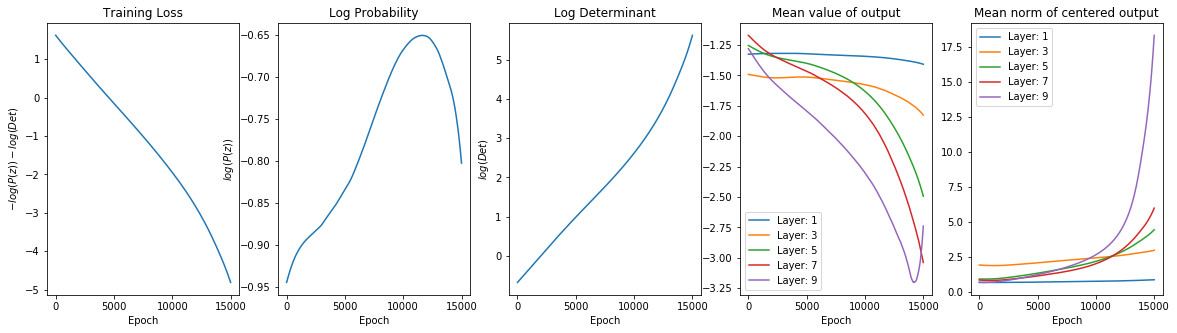

In [17]:
# Plot training NLL
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].plot(loss)
ax[1].plot(logpz)
ax[2].plot(logdet)
ax[3].plot(np.array(logits_mean))
ax[4].plot(np.array(logits_size))


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

ax[3].set_title('Mean value of output')
ax[3].set_xlabel('Epoch')
ax[3].legend(['Layer: {}'.format(i+1) for i in range(0, len(model.layers), len(model.layers)//n_layers)])

ax[4].set_title('Mean norm of centered output')
ax[4].set_xlabel('Epoch')
ax[4].legend(['Layer: {}'.format(i+1) for i in range(0, len(model.layers), len(model.layers)//n_layers)])

plt.show(fig)

In [18]:
ani = create_animation_simplex(intermediate_results, easy_target)

In [19]:
HTML(ani.to_html5_video())

## NVP-like flow mixed case

In [20]:
model2 = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])
dev = torch.device('cpu')

In [21]:
epochs = 15000

In [22]:
model2 = model2.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5)

loss2 = []
logpz2 = []
logdet2 = []

n_layers = 5  # Layers to monitor

# Output at some layers
logits_mean2 = []
logits_size2 = []

softmx = nn.Softmax(dim=1)

intermediate_results2 = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    zs, _logdet = model2(torch_hard_logits)
    preds = zs[-1]
    _probs = softmx(preds)
    
    if (_probs != _probs).any():
        break
    
    means = []
    sizes = []
    for i in range(0, len(model2.layers), len(model2.layers)//n_layers):
        z = zs[i].detach().numpy()
        means.append(np.mean(z))
        sizes.append(np.mean(np.linalg.norm(z-np.mean(z, axis=1, keepdims=True), axis=1)))

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.log(_probs.gather(1, torch_hard_target.view(-1, 1))))
    _loss = -_logpz - _logdet

    _loss.backward()
    optimizer.step()

    loss2.append(_loss.item())
    logpz2.append(_logpz.item())
    logdet2.append(_logdet.item())
    
    logits_mean2.append(means)
    logits_size2.append(sizes)

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss2[-1], logpz2[-1])
              + ', log(det): {:.3f}, mean(logits): {:.3f}, size(logits): {:.3f}'.format(logdet2[-1],
                                                                                        np.mean(np.array(logits_mean2[-1])),
                                                                                        np.mean(np.array(logits_size2[-1])))
             )
        intermediate_results2.append(preds.detach().numpy())

epoch: 9, at time: 0.23, loss: 0.819, log(pz): -0.951, log(det): 0.132, mean(logits): -1.317, size(logits): 0.866
epoch: 19, at time: 0.48, loss: 0.815, log(pz): -0.951, log(det): 0.136, mean(logits): -1.318, size(logits): 0.866
epoch: 29, at time: 0.69, loss: 0.811, log(pz): -0.951, log(det): 0.140, mean(logits): -1.319, size(logits): 0.867
epoch: 39, at time: 0.91, loss: 0.806, log(pz): -0.951, log(det): 0.145, mean(logits): -1.320, size(logits): 0.868
epoch: 49, at time: 1.13, loss: 0.802, log(pz): -0.951, log(det): 0.149, mean(logits): -1.321, size(logits): 0.869
epoch: 59, at time: 1.35, loss: 0.798, log(pz): -0.951, log(det): 0.153, mean(logits): -1.322, size(logits): 0.869
epoch: 69, at time: 1.57, loss: 0.793, log(pz): -0.951, log(det): 0.157, mean(logits): -1.323, size(logits): 0.870
epoch: 79, at time: 1.79, loss: 0.789, log(pz): -0.950, log(det): 0.162, mean(logits): -1.324, size(logits): 0.871
epoch: 89, at time: 2.00, loss: 0.785, log(pz): -0.950, log(det): 0.166, mean(log

epoch: 719, at time: 15.62, loss: 0.512, log(pz): -0.950, log(det): 0.438, mean(logits): -1.391, size(logits): 0.927
epoch: 729, at time: 15.84, loss: 0.508, log(pz): -0.950, log(det): 0.442, mean(logits): -1.392, size(logits): 0.928
epoch: 739, at time: 16.05, loss: 0.504, log(pz): -0.950, log(det): 0.447, mean(logits): -1.393, size(logits): 0.929
epoch: 749, at time: 16.26, loss: 0.499, log(pz): -0.950, log(det): 0.451, mean(logits): -1.395, size(logits): 0.930
epoch: 759, at time: 16.48, loss: 0.495, log(pz): -0.950, log(det): 0.455, mean(logits): -1.396, size(logits): 0.931
epoch: 769, at time: 16.70, loss: 0.491, log(pz): -0.950, log(det): 0.460, mean(logits): -1.397, size(logits): 0.932
epoch: 779, at time: 16.91, loss: 0.486, log(pz): -0.951, log(det): 0.464, mean(logits): -1.398, size(logits): 0.933
epoch: 789, at time: 17.13, loss: 0.482, log(pz): -0.951, log(det): 0.469, mean(logits): -1.399, size(logits): 0.934
epoch: 799, at time: 17.35, loss: 0.478, log(pz): -0.951, log(de

epoch: 1419, at time: 30.69, loss: 0.212, log(pz): -0.964, log(det): 0.752, mean(logits): -1.470, size(logits): 1.009
epoch: 1429, at time: 30.91, loss: 0.208, log(pz): -0.964, log(det): 0.757, mean(logits): -1.471, size(logits): 1.010
epoch: 1439, at time: 31.12, loss: 0.203, log(pz): -0.965, log(det): 0.761, mean(logits): -1.472, size(logits): 1.011
epoch: 1449, at time: 31.33, loss: 0.199, log(pz): -0.965, log(det): 0.766, mean(logits): -1.473, size(logits): 1.013
epoch: 1459, at time: 31.55, loss: 0.195, log(pz): -0.965, log(det): 0.770, mean(logits): -1.474, size(logits): 1.014
epoch: 1469, at time: 31.76, loss: 0.191, log(pz): -0.965, log(det): 0.775, mean(logits): -1.476, size(logits): 1.015
epoch: 1479, at time: 31.98, loss: 0.186, log(pz): -0.966, log(det): 0.779, mean(logits): -1.477, size(logits): 1.017
epoch: 1489, at time: 32.19, loss: 0.182, log(pz): -0.966, log(det): 0.784, mean(logits): -1.478, size(logits): 1.018
epoch: 1499, at time: 32.41, loss: 0.178, log(pz): -0.96

epoch: 2119, at time: 45.78, loss: -0.081, log(pz): -0.992, log(det): 1.073, mean(logits): -1.550, size(logits): 1.107
epoch: 2129, at time: 45.99, loss: -0.085, log(pz): -0.993, log(det): 1.077, mean(logits): -1.551, size(logits): 1.108
epoch: 2139, at time: 46.21, loss: -0.089, log(pz): -0.993, log(det): 1.082, mean(logits): -1.552, size(logits): 1.110
epoch: 2149, at time: 46.42, loss: -0.093, log(pz): -0.994, log(det): 1.087, mean(logits): -1.554, size(logits): 1.111
epoch: 2159, at time: 46.64, loss: -0.097, log(pz): -0.994, log(det): 1.091, mean(logits): -1.555, size(logits): 1.113
epoch: 2169, at time: 46.85, loss: -0.101, log(pz): -0.995, log(det): 1.096, mean(logits): -1.556, size(logits): 1.114
epoch: 2179, at time: 47.07, loss: -0.105, log(pz): -0.995, log(det): 1.101, mean(logits): -1.557, size(logits): 1.116
epoch: 2189, at time: 47.28, loss: -0.109, log(pz): -0.996, log(det): 1.105, mean(logits): -1.558, size(logits): 1.117
epoch: 2199, at time: 47.50, loss: -0.113, log(p

epoch: 2809, at time: 60.76, loss: -0.352, log(pz): -1.038, log(det): 1.391, mean(logits): -1.629, size(logits): 1.214
epoch: 2819, at time: 60.97, loss: -0.356, log(pz): -1.039, log(det): 1.395, mean(logits): -1.630, size(logits): 1.216
epoch: 2829, at time: 61.19, loss: -0.360, log(pz): -1.040, log(det): 1.400, mean(logits): -1.632, size(logits): 1.217
epoch: 2839, at time: 61.40, loss: -0.364, log(pz): -1.041, log(det): 1.404, mean(logits): -1.633, size(logits): 1.219
epoch: 2849, at time: 61.62, loss: -0.367, log(pz): -1.042, log(det): 1.409, mean(logits): -1.634, size(logits): 1.221
epoch: 2859, at time: 61.83, loss: -0.371, log(pz): -1.042, log(det): 1.414, mean(logits): -1.635, size(logits): 1.222
epoch: 2869, at time: 62.05, loss: -0.375, log(pz): -1.043, log(det): 1.418, mean(logits): -1.636, size(logits): 1.224
epoch: 2879, at time: 62.26, loss: -0.379, log(pz): -1.044, log(det): 1.423, mean(logits): -1.637, size(logits): 1.225
epoch: 2889, at time: 62.48, loss: -0.382, log(p

epoch: 3499, at time: 75.64, loss: -0.602, log(pz): -1.096, log(det): 1.699, mean(logits): -1.698, size(logits): 1.319
epoch: 3509, at time: 75.86, loss: -0.606, log(pz): -1.097, log(det): 1.703, mean(logits): -1.699, size(logits): 1.320
epoch: 3519, at time: 76.08, loss: -0.609, log(pz): -1.098, log(det): 1.707, mean(logits): -1.700, size(logits): 1.321
epoch: 3529, at time: 76.29, loss: -0.613, log(pz): -1.099, log(det): 1.711, mean(logits): -1.701, size(logits): 1.323
epoch: 3539, at time: 76.51, loss: -0.616, log(pz): -1.100, log(det): 1.716, mean(logits): -1.702, size(logits): 1.324
epoch: 3549, at time: 76.72, loss: -0.620, log(pz): -1.100, log(det): 1.720, mean(logits): -1.703, size(logits): 1.326
epoch: 3559, at time: 76.94, loss: -0.623, log(pz): -1.101, log(det): 1.724, mean(logits): -1.703, size(logits): 1.327
epoch: 3569, at time: 77.15, loss: -0.627, log(pz): -1.102, log(det): 1.729, mean(logits): -1.704, size(logits): 1.328
epoch: 3579, at time: 77.37, loss: -0.630, log(p

epoch: 4189, at time: 90.55, loss: -0.836, log(pz): -1.146, log(det): 1.982, mean(logits): -1.745, size(logits): 1.403
epoch: 4199, at time: 90.77, loss: -0.839, log(pz): -1.147, log(det): 1.986, mean(logits): -1.745, size(logits): 1.404
epoch: 4209, at time: 90.99, loss: -0.842, log(pz): -1.147, log(det): 1.990, mean(logits): -1.746, size(logits): 1.405
epoch: 4219, at time: 91.20, loss: -0.846, log(pz): -1.148, log(det): 1.994, mean(logits): -1.746, size(logits): 1.406
epoch: 4229, at time: 91.42, loss: -0.849, log(pz): -1.148, log(det): 1.997, mean(logits): -1.747, size(logits): 1.407
epoch: 4239, at time: 91.64, loss: -0.852, log(pz): -1.149, log(det): 2.001, mean(logits): -1.747, size(logits): 1.408
epoch: 4249, at time: 91.85, loss: -0.856, log(pz): -1.150, log(det): 2.005, mean(logits): -1.748, size(logits): 1.409
epoch: 4259, at time: 92.07, loss: -0.859, log(pz): -1.150, log(det): 2.009, mean(logits): -1.748, size(logits): 1.410
epoch: 4269, at time: 92.29, loss: -0.862, log(p

epoch: 4879, at time: 105.50, loss: -1.060, log(pz): -1.179, log(det): 2.239, mean(logits): -1.769, size(logits): 1.466
epoch: 4889, at time: 105.72, loss: -1.064, log(pz): -1.179, log(det): 2.243, mean(logits): -1.769, size(logits): 1.467
epoch: 4899, at time: 105.93, loss: -1.067, log(pz): -1.179, log(det): 2.246, mean(logits): -1.769, size(logits): 1.467
epoch: 4909, at time: 106.15, loss: -1.070, log(pz): -1.180, log(det): 2.250, mean(logits): -1.769, size(logits): 1.468
epoch: 4919, at time: 106.36, loss: -1.073, log(pz): -1.180, log(det): 2.253, mean(logits): -1.769, size(logits): 1.469
epoch: 4929, at time: 106.58, loss: -1.076, log(pz): -1.180, log(det): 2.257, mean(logits): -1.770, size(logits): 1.470
epoch: 4939, at time: 106.80, loss: -1.080, log(pz): -1.181, log(det): 2.260, mean(logits): -1.770, size(logits): 1.471
epoch: 4949, at time: 107.01, loss: -1.083, log(pz): -1.181, log(det): 2.264, mean(logits): -1.770, size(logits): 1.471
epoch: 4959, at time: 107.23, loss: -1.0

epoch: 5569, at time: 120.47, loss: -1.282, log(pz): -1.197, log(det): 2.479, mean(logits): -1.778, size(logits): 1.520
epoch: 5579, at time: 120.68, loss: -1.285, log(pz): -1.198, log(det): 2.482, mean(logits): -1.778, size(logits): 1.521
epoch: 5589, at time: 120.90, loss: -1.288, log(pz): -1.198, log(det): 2.486, mean(logits): -1.779, size(logits): 1.522
epoch: 5599, at time: 121.12, loss: -1.291, log(pz): -1.198, log(det): 2.489, mean(logits): -1.779, size(logits): 1.523
epoch: 5609, at time: 121.33, loss: -1.295, log(pz): -1.198, log(det): 2.493, mean(logits): -1.779, size(logits): 1.523
epoch: 5619, at time: 121.55, loss: -1.298, log(pz): -1.198, log(det): 2.496, mean(logits): -1.779, size(logits): 1.524
epoch: 5629, at time: 121.78, loss: -1.301, log(pz): -1.199, log(det): 2.500, mean(logits): -1.779, size(logits): 1.525
epoch: 5639, at time: 121.99, loss: -1.304, log(pz): -1.199, log(det): 2.503, mean(logits): -1.779, size(logits): 1.526
epoch: 5649, at time: 122.21, loss: -1.3

epoch: 6259, at time: 135.56, loss: -1.507, log(pz): -1.210, log(det): 2.717, mean(logits): -1.783, size(logits): 1.575
epoch: 6269, at time: 135.78, loss: -1.510, log(pz): -1.210, log(det): 2.720, mean(logits): -1.783, size(logits): 1.576
epoch: 6279, at time: 135.99, loss: -1.514, log(pz): -1.210, log(det): 2.724, mean(logits): -1.783, size(logits): 1.577
epoch: 6289, at time: 136.21, loss: -1.517, log(pz): -1.210, log(det): 2.727, mean(logits): -1.783, size(logits): 1.578
epoch: 6299, at time: 136.42, loss: -1.520, log(pz): -1.210, log(det): 2.731, mean(logits): -1.783, size(logits): 1.579
epoch: 6309, at time: 136.64, loss: -1.524, log(pz): -1.211, log(det): 2.734, mean(logits): -1.783, size(logits): 1.579
epoch: 6319, at time: 136.86, loss: -1.527, log(pz): -1.211, log(det): 2.738, mean(logits): -1.783, size(logits): 1.580
epoch: 6329, at time: 137.07, loss: -1.530, log(pz): -1.211, log(det): 2.741, mean(logits): -1.783, size(logits): 1.581
epoch: 6339, at time: 137.29, loss: -1.5

epoch: 6949, at time: 150.52, loss: -1.740, log(pz): -1.220, log(det): 2.960, mean(logits): -1.786, size(logits): 1.639
epoch: 6959, at time: 150.74, loss: -1.744, log(pz): -1.220, log(det): 2.964, mean(logits): -1.786, size(logits): 1.640
epoch: 6969, at time: 150.95, loss: -1.747, log(pz): -1.221, log(det): 2.968, mean(logits): -1.786, size(logits): 1.641
epoch: 6979, at time: 151.17, loss: -1.750, log(pz): -1.221, log(det): 2.971, mean(logits): -1.786, size(logits): 1.642
epoch: 6989, at time: 151.39, loss: -1.754, log(pz): -1.221, log(det): 2.975, mean(logits): -1.787, size(logits): 1.643
epoch: 6999, at time: 151.60, loss: -1.757, log(pz): -1.221, log(det): 2.978, mean(logits): -1.787, size(logits): 1.644
epoch: 7009, at time: 151.82, loss: -1.761, log(pz): -1.222, log(det): 2.982, mean(logits): -1.787, size(logits): 1.645
epoch: 7019, at time: 152.04, loss: -1.764, log(pz): -1.222, log(det): 2.986, mean(logits): -1.787, size(logits): 1.646
epoch: 7029, at time: 152.25, loss: -1.7

epoch: 7639, at time: 165.52, loss: -1.973, log(pz): -1.239, log(det): 3.212, mean(logits): -1.792, size(logits): 1.714
epoch: 7649, at time: 165.74, loss: -1.976, log(pz): -1.239, log(det): 3.215, mean(logits): -1.792, size(logits): 1.715
epoch: 7659, at time: 165.96, loss: -1.980, log(pz): -1.239, log(det): 3.219, mean(logits): -1.792, size(logits): 1.716
epoch: 7669, at time: 166.18, loss: -1.983, log(pz): -1.240, log(det): 3.223, mean(logits): -1.792, size(logits): 1.717
epoch: 7679, at time: 166.39, loss: -1.986, log(pz): -1.240, log(det): 3.226, mean(logits): -1.792, size(logits): 1.719
epoch: 7689, at time: 166.61, loss: -1.990, log(pz): -1.240, log(det): 3.230, mean(logits): -1.792, size(logits): 1.720
epoch: 7699, at time: 166.92, loss: -1.993, log(pz): -1.241, log(det): 3.234, mean(logits): -1.793, size(logits): 1.721
epoch: 7709, at time: 167.14, loss: -1.996, log(pz): -1.241, log(det): 3.238, mean(logits): -1.793, size(logits): 1.722
epoch: 7719, at time: 167.36, loss: -2.0

epoch: 8329, at time: 180.66, loss: -2.201, log(pz): -1.271, log(det): 3.472, mean(logits): -1.802, size(logits): 1.800
epoch: 8339, at time: 180.88, loss: -2.205, log(pz): -1.271, log(det): 3.476, mean(logits): -1.802, size(logits): 1.801
epoch: 8349, at time: 181.10, loss: -2.208, log(pz): -1.272, log(det): 3.480, mean(logits): -1.802, size(logits): 1.802
epoch: 8359, at time: 181.32, loss: -2.211, log(pz): -1.272, log(det): 3.483, mean(logits): -1.802, size(logits): 1.804
epoch: 8369, at time: 181.53, loss: -2.214, log(pz): -1.273, log(det): 3.487, mean(logits): -1.803, size(logits): 1.805
epoch: 8379, at time: 181.75, loss: -2.218, log(pz): -1.273, log(det): 3.491, mean(logits): -1.803, size(logits): 1.806
epoch: 8389, at time: 181.97, loss: -2.221, log(pz): -1.274, log(det): 3.495, mean(logits): -1.803, size(logits): 1.808
epoch: 8399, at time: 182.18, loss: -2.224, log(pz): -1.275, log(det): 3.499, mean(logits): -1.803, size(logits): 1.809
epoch: 8409, at time: 182.40, loss: -2.2

epoch: 9019, at time: 195.63, loss: -2.420, log(pz): -1.319, log(det): 3.739, mean(logits): -1.816, size(logits): 1.896
epoch: 9029, at time: 195.85, loss: -2.423, log(pz): -1.320, log(det): 3.743, mean(logits): -1.817, size(logits): 1.897
epoch: 9039, at time: 196.06, loss: -2.426, log(pz): -1.321, log(det): 3.747, mean(logits): -1.817, size(logits): 1.899
epoch: 9049, at time: 196.28, loss: -2.429, log(pz): -1.322, log(det): 3.751, mean(logits): -1.817, size(logits): 1.900
epoch: 9059, at time: 196.50, loss: -2.432, log(pz): -1.323, log(det): 3.755, mean(logits): -1.817, size(logits): 1.901
epoch: 9069, at time: 196.71, loss: -2.435, log(pz): -1.324, log(det): 3.759, mean(logits): -1.817, size(logits): 1.903
epoch: 9079, at time: 196.93, loss: -2.438, log(pz): -1.325, log(det): 3.763, mean(logits): -1.818, size(logits): 1.904
epoch: 9089, at time: 197.15, loss: -2.441, log(pz): -1.325, log(det): 3.767, mean(logits): -1.818, size(logits): 1.906
epoch: 9099, at time: 197.36, loss: -2.4

epoch: 9709, at time: 210.61, loss: -2.620, log(pz): -1.379, log(det): 3.999, mean(logits): -1.830, size(logits): 1.989
epoch: 9719, at time: 210.82, loss: -2.623, log(pz): -1.379, log(det): 4.002, mean(logits): -1.830, size(logits): 1.990
epoch: 9729, at time: 211.04, loss: -2.626, log(pz): -1.380, log(det): 4.006, mean(logits): -1.830, size(logits): 1.991
epoch: 9739, at time: 211.26, loss: -2.629, log(pz): -1.380, log(det): 4.009, mean(logits): -1.831, size(logits): 1.992
epoch: 9749, at time: 211.47, loss: -2.632, log(pz): -1.381, log(det): 4.013, mean(logits): -1.831, size(logits): 1.994
epoch: 9759, at time: 211.69, loss: -2.635, log(pz): -1.381, log(det): 4.017, mean(logits): -1.831, size(logits): 1.995
epoch: 9769, at time: 211.91, loss: -2.638, log(pz): -1.382, log(det): 4.020, mean(logits): -1.831, size(logits): 1.996
epoch: 9779, at time: 212.13, loss: -2.641, log(pz): -1.382, log(det): 4.024, mean(logits): -1.831, size(logits): 1.997
epoch: 9789, at time: 212.34, loss: -2.6

epoch: 10389, at time: 225.36, loss: -2.805, log(pz): -1.440, log(det): 4.245, mean(logits): -1.847, size(logits): 2.079
epoch: 10399, at time: 225.58, loss: -2.808, log(pz): -1.440, log(det): 4.248, mean(logits): -1.847, size(logits): 2.081
epoch: 10409, at time: 225.80, loss: -2.810, log(pz): -1.441, log(det): 4.252, mean(logits): -1.847, size(logits): 2.082
epoch: 10419, at time: 226.03, loss: -2.812, log(pz): -1.442, log(det): 4.255, mean(logits): -1.847, size(logits): 2.083
epoch: 10429, at time: 226.26, loss: -2.815, log(pz): -1.443, log(det): 4.258, mean(logits): -1.848, size(logits): 2.084
epoch: 10439, at time: 226.49, loss: -2.817, log(pz): -1.444, log(det): 4.261, mean(logits): -1.848, size(logits): 2.086
epoch: 10449, at time: 226.72, loss: -2.820, log(pz): -1.445, log(det): 4.265, mean(logits): -1.848, size(logits): 2.087
epoch: 10459, at time: 226.94, loss: -2.822, log(pz): -1.446, log(det): 4.268, mean(logits): -1.848, size(logits): 2.088
epoch: 10469, at time: 227.17, l

epoch: 11069, at time: 240.82, loss: -2.954, log(pz): -1.494, log(det): 4.448, mean(logits): -1.860, size(logits): 2.158
epoch: 11079, at time: 241.05, loss: -2.956, log(pz): -1.495, log(det): 4.450, mean(logits): -1.860, size(logits): 2.159
epoch: 11089, at time: 241.28, loss: -2.958, log(pz): -1.495, log(det): 4.453, mean(logits): -1.861, size(logits): 2.160
epoch: 11099, at time: 241.50, loss: -2.960, log(pz): -1.496, log(det): 4.456, mean(logits): -1.861, size(logits): 2.161
epoch: 11109, at time: 241.73, loss: -2.962, log(pz): -1.497, log(det): 4.458, mean(logits): -1.861, size(logits): 2.162
epoch: 11119, at time: 241.96, loss: -2.964, log(pz): -1.497, log(det): 4.461, mean(logits): -1.861, size(logits): 2.163
epoch: 11129, at time: 242.19, loss: -2.966, log(pz): -1.498, log(det): 4.463, mean(logits): -1.861, size(logits): 2.164
epoch: 11139, at time: 242.46, loss: -2.968, log(pz): -1.498, log(det): 4.466, mean(logits): -1.861, size(logits): 2.165
epoch: 11149, at time: 242.68, l

epoch: 11749, at time: 255.88, loss: -3.083, log(pz): -1.531, log(det): 4.614, mean(logits): -1.871, size(logits): 2.220
epoch: 11759, at time: 256.10, loss: -3.085, log(pz): -1.531, log(det): 4.616, mean(logits): -1.871, size(logits): 2.221
epoch: 11769, at time: 256.31, loss: -3.086, log(pz): -1.532, log(det): 4.618, mean(logits): -1.871, size(logits): 2.221
epoch: 11779, at time: 256.53, loss: -3.088, log(pz): -1.532, log(det): 4.621, mean(logits): -1.871, size(logits): 2.222
epoch: 11789, at time: 256.74, loss: -3.090, log(pz): -1.533, log(det): 4.623, mean(logits): -1.871, size(logits): 2.223
epoch: 11799, at time: 256.96, loss: -3.092, log(pz): -1.533, log(det): 4.625, mean(logits): -1.871, size(logits): 2.223
epoch: 11809, at time: 257.18, loss: -3.093, log(pz): -1.534, log(det): 4.627, mean(logits): -1.871, size(logits): 2.224
epoch: 11819, at time: 257.39, loss: -3.095, log(pz): -1.534, log(det): 4.629, mean(logits): -1.872, size(logits): 2.225
epoch: 11829, at time: 257.61, l

epoch: 12429, at time: 270.72, loss: -3.195, log(pz): -1.546, log(det): 4.742, mean(logits): -1.876, size(logits): 2.256
epoch: 12439, at time: 270.93, loss: -3.197, log(pz): -1.547, log(det): 4.744, mean(logits): -1.876, size(logits): 2.257
epoch: 12449, at time: 271.16, loss: -3.199, log(pz): -1.547, log(det): 4.745, mean(logits): -1.876, size(logits): 2.257
epoch: 12459, at time: 271.37, loss: -3.200, log(pz): -1.547, log(det): 4.747, mean(logits): -1.876, size(logits): 2.258
epoch: 12469, at time: 271.59, loss: -3.202, log(pz): -1.547, log(det): 4.749, mean(logits): -1.876, size(logits): 2.258
epoch: 12479, at time: 271.80, loss: -3.204, log(pz): -1.547, log(det): 4.751, mean(logits): -1.876, size(logits): 2.259
epoch: 12489, at time: 272.02, loss: -3.205, log(pz): -1.547, log(det): 4.752, mean(logits): -1.876, size(logits): 2.259
epoch: 12499, at time: 272.24, loss: -3.207, log(pz): -1.547, log(det): 4.754, mean(logits): -1.876, size(logits): 2.260
epoch: 12509, at time: 272.45, l

epoch: 13109, at time: 285.66, loss: -3.307, log(pz): -1.554, log(det): 4.861, mean(logits): -1.880, size(logits): 2.291
epoch: 13119, at time: 285.87, loss: -3.309, log(pz): -1.554, log(det): 4.863, mean(logits): -1.880, size(logits): 2.291
epoch: 13129, at time: 286.09, loss: -3.310, log(pz): -1.555, log(det): 4.865, mean(logits): -1.880, size(logits): 2.292
epoch: 13139, at time: 286.30, loss: -3.312, log(pz): -1.555, log(det): 4.866, mean(logits): -1.880, size(logits): 2.292
epoch: 13149, at time: 286.51, loss: -3.314, log(pz): -1.555, log(det): 4.868, mean(logits): -1.880, size(logits): 2.293
epoch: 13159, at time: 286.73, loss: -3.315, log(pz): -1.555, log(det): 4.870, mean(logits): -1.880, size(logits): 2.293
epoch: 13169, at time: 286.94, loss: -3.317, log(pz): -1.555, log(det): 4.872, mean(logits): -1.880, size(logits): 2.294
epoch: 13179, at time: 287.16, loss: -3.319, log(pz): -1.555, log(det): 4.873, mean(logits): -1.880, size(logits): 2.295
epoch: 13189, at time: 287.37, l

epoch: 13789, at time: 300.57, loss: -3.422, log(pz): -1.566, log(det): 4.988, mean(logits): -1.884, size(logits): 2.335
epoch: 13799, at time: 300.79, loss: -3.424, log(pz): -1.566, log(det): 4.990, mean(logits): -1.884, size(logits): 2.336
epoch: 13809, at time: 301.01, loss: -3.426, log(pz): -1.566, log(det): 4.992, mean(logits): -1.884, size(logits): 2.337
epoch: 13819, at time: 301.23, loss: -3.427, log(pz): -1.567, log(det): 4.994, mean(logits): -1.884, size(logits): 2.337
epoch: 13829, at time: 301.45, loss: -3.429, log(pz): -1.567, log(det): 4.996, mean(logits): -1.885, size(logits): 2.338
epoch: 13839, at time: 301.66, loss: -3.431, log(pz): -1.567, log(det): 4.998, mean(logits): -1.885, size(logits): 2.339
epoch: 13849, at time: 301.88, loss: -3.433, log(pz): -1.567, log(det): 5.000, mean(logits): -1.885, size(logits): 2.340
epoch: 13859, at time: 302.15, loss: -3.434, log(pz): -1.567, log(det): 5.002, mean(logits): -1.885, size(logits): 2.340
epoch: 13869, at time: 302.37, l

epoch: 14469, at time: 315.45, loss: -3.543, log(pz): -1.581, log(det): 5.123, mean(logits): -1.890, size(logits): 2.392
epoch: 14479, at time: 315.66, loss: -3.544, log(pz): -1.581, log(det): 5.125, mean(logits): -1.890, size(logits): 2.393
epoch: 14489, at time: 315.88, loss: -3.546, log(pz): -1.581, log(det): 5.128, mean(logits): -1.890, size(logits): 2.394
epoch: 14499, at time: 316.10, loss: -3.548, log(pz): -1.582, log(det): 5.130, mean(logits): -1.890, size(logits): 2.395
epoch: 14509, at time: 316.31, loss: -3.550, log(pz): -1.582, log(det): 5.132, mean(logits): -1.891, size(logits): 2.397
epoch: 14519, at time: 316.53, loss: -3.552, log(pz): -1.583, log(det): 5.134, mean(logits): -1.891, size(logits): 2.398
epoch: 14529, at time: 316.74, loss: -3.553, log(pz): -1.583, log(det): 5.137, mean(logits): -1.891, size(logits): 2.399
epoch: 14539, at time: 316.97, loss: -3.555, log(pz): -1.584, log(det): 5.139, mean(logits): -1.891, size(logits): 2.400
epoch: 14549, at time: 317.18, l

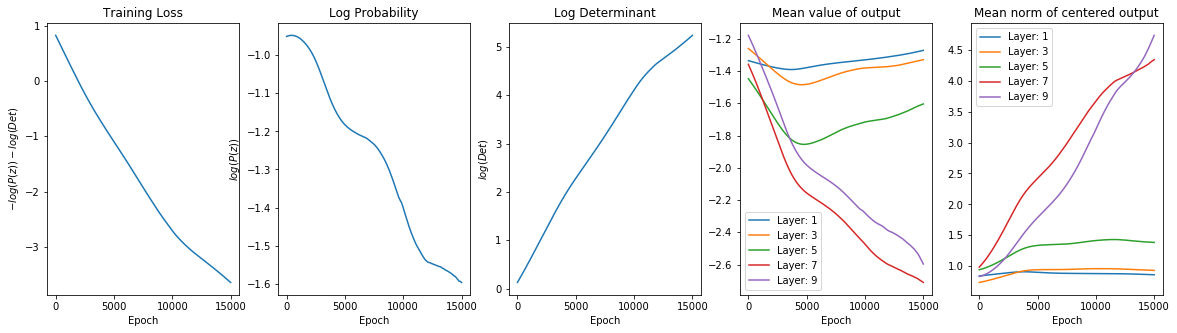

In [23]:
# Plot training NLL
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].plot(loss2)
ax[1].plot(logpz2)
ax[2].plot(logdet2)
ax[3].plot(np.array(logits_mean2))
ax[4].plot(np.array(logits_size2))


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

ax[3].set_title('Mean value of output')
ax[3].set_xlabel('Epoch')
ax[3].legend(['Layer: {}'.format(i+1) for i in range(0, len(model2.layers), len(model2.layers)//n_layers)])

ax[4].set_title('Mean norm of centered output')
ax[4].set_xlabel('Epoch')
ax[4].legend(['Layer: {}'.format(i+1) for i in range(0, len(model2.layers), len(model2.layers)//n_layers)])

plt.show(fig)

In [27]:
ani2 = create_animation_simplex(intermediate_results2, hard_target)

In [28]:
HTML(ani2.to_html5_video())